In [ ]:
!nvidia-smi

Mon Apr 21 08:22:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             28W /   70W |     302MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings(action="ignore")

In [1]:
!pip install mlflow
!pip install pyngrok

  Using cached pyngrok-7.2.8-py3-none-any.whl.metadata (10 kB)
Using cached pyngrok-7.2.8-py3-none-any.whl (25 kB)


In [3]:
import mlflow
import mlflow.sklearn

In [4]:
mlflow.set_experiment("Heart Disease Prediction")

2025/05/17 07:21:48 INFO mlflow.tracking.fluent: Experiment with name 'Heart Disease Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/289201512491580559', creation_time=1747466508014, experiment_id='289201512491580559', last_update_time=1747466508014, lifecycle_stage='active', name='Heart Disease Prediction', tags={}>

In [5]:
#establish gateway
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.set_tracking_uri("http://localhost:5000")

In [6]:
from pyngrok import ngrok

In [19]:
from google.colab import userdata
token = userdata.get('ngrokToken') #secret1

In [20]:
ngrok.set_auth_token(token)

In [21]:
public_url = ngrok.connect(5000).public_url
print("url", public_url)

url https://6a97-34-90-58-191.ngrok-free.app


In [22]:
from google.colab import files
uploaded = files.upload()

Saving the_heart_ds.csv to the_heart_ds.csv


In [23]:
df = pd.read_csv('the_heart_ds.csv')

In [24]:
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [25]:
df.tail()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1
1189,38,1,3,138,175,0,0,173,0,0.0,1,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


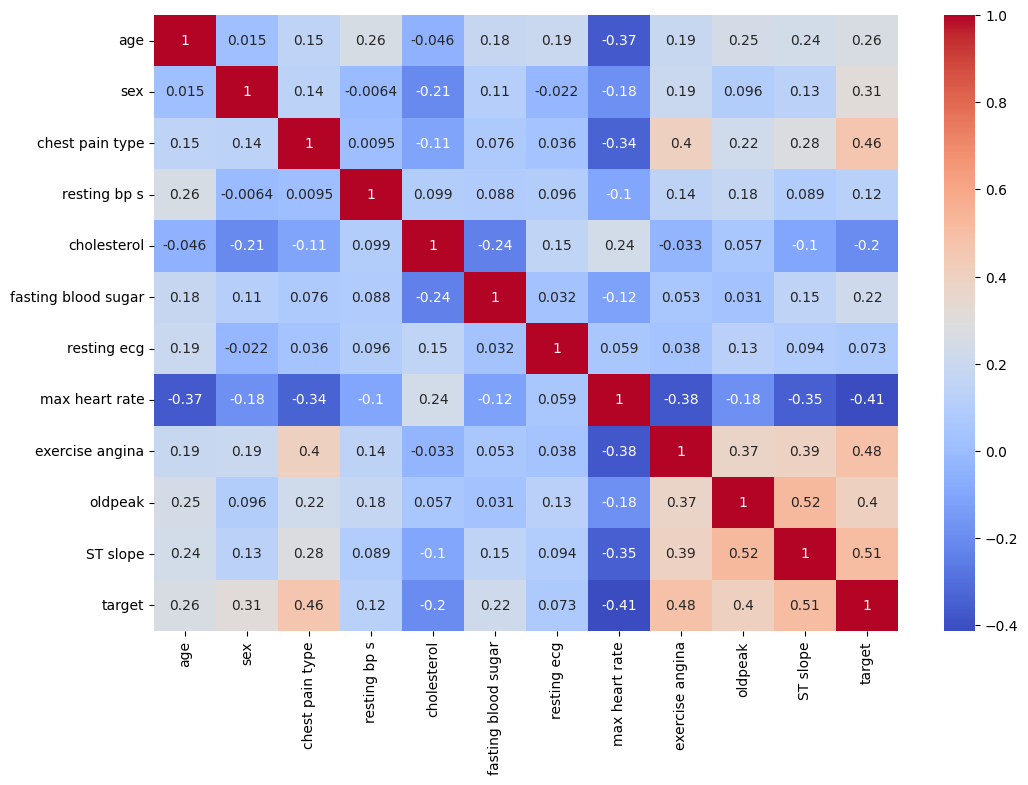

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

In [31]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

In [32]:
fig = px.parallel_coordinates(df, color="target",
                             dimensions=df.columns[:-1],
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             title="Parallel Coordinates Plot of Heart Disease Features")


In [33]:
fig.show()

In [34]:
pca = PCA(n_components=3)
components = pca.fit_transform(df.drop('target', axis=1))
components_df = pd.DataFrame(components, columns=['PC 1', 'PC 2', 'PC 3'])
components_df = pd.concat([components_df, df], axis=1)

fig = px.scatter_3d(
    components_df, x='PC 1', y='PC 2', z='PC 3', color=df['target'],
    size=df['age'], hover_data=df.columns,
    title="3D PCA Projection with Target Coloring"
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

<Figure size 1500x900 with 0 Axes>

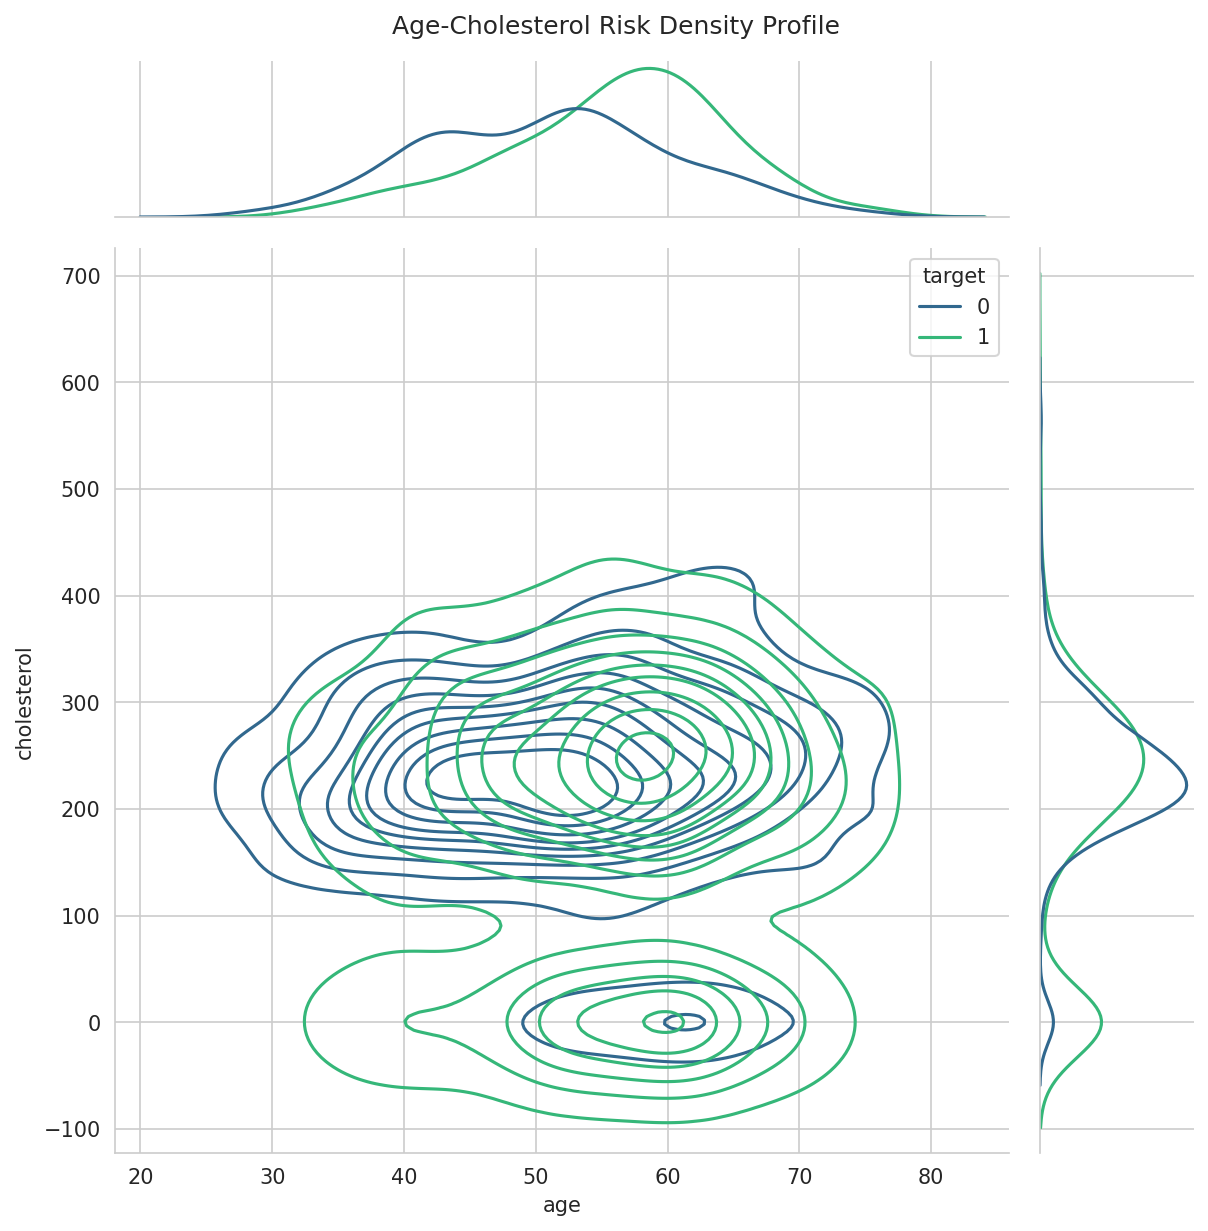

In [35]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=df, x='age', y='cholesterol',
            hue='target', kind='kde',
            palette='viridis', height=8)
plt.suptitle("Age-Cholesterol Risk Density Profile", y=1.02)
plt.show()

In [36]:
def create_radar_chart(sample):
    categories = df.columns[:-1]
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=sample.values,
        theta=categories,
        fill='toself',
        name='Patient Features'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, df[categories].max().max()]
            )),
        showlegend=True,
        title="Radar Chart of Patient Features"
    )
    return fig

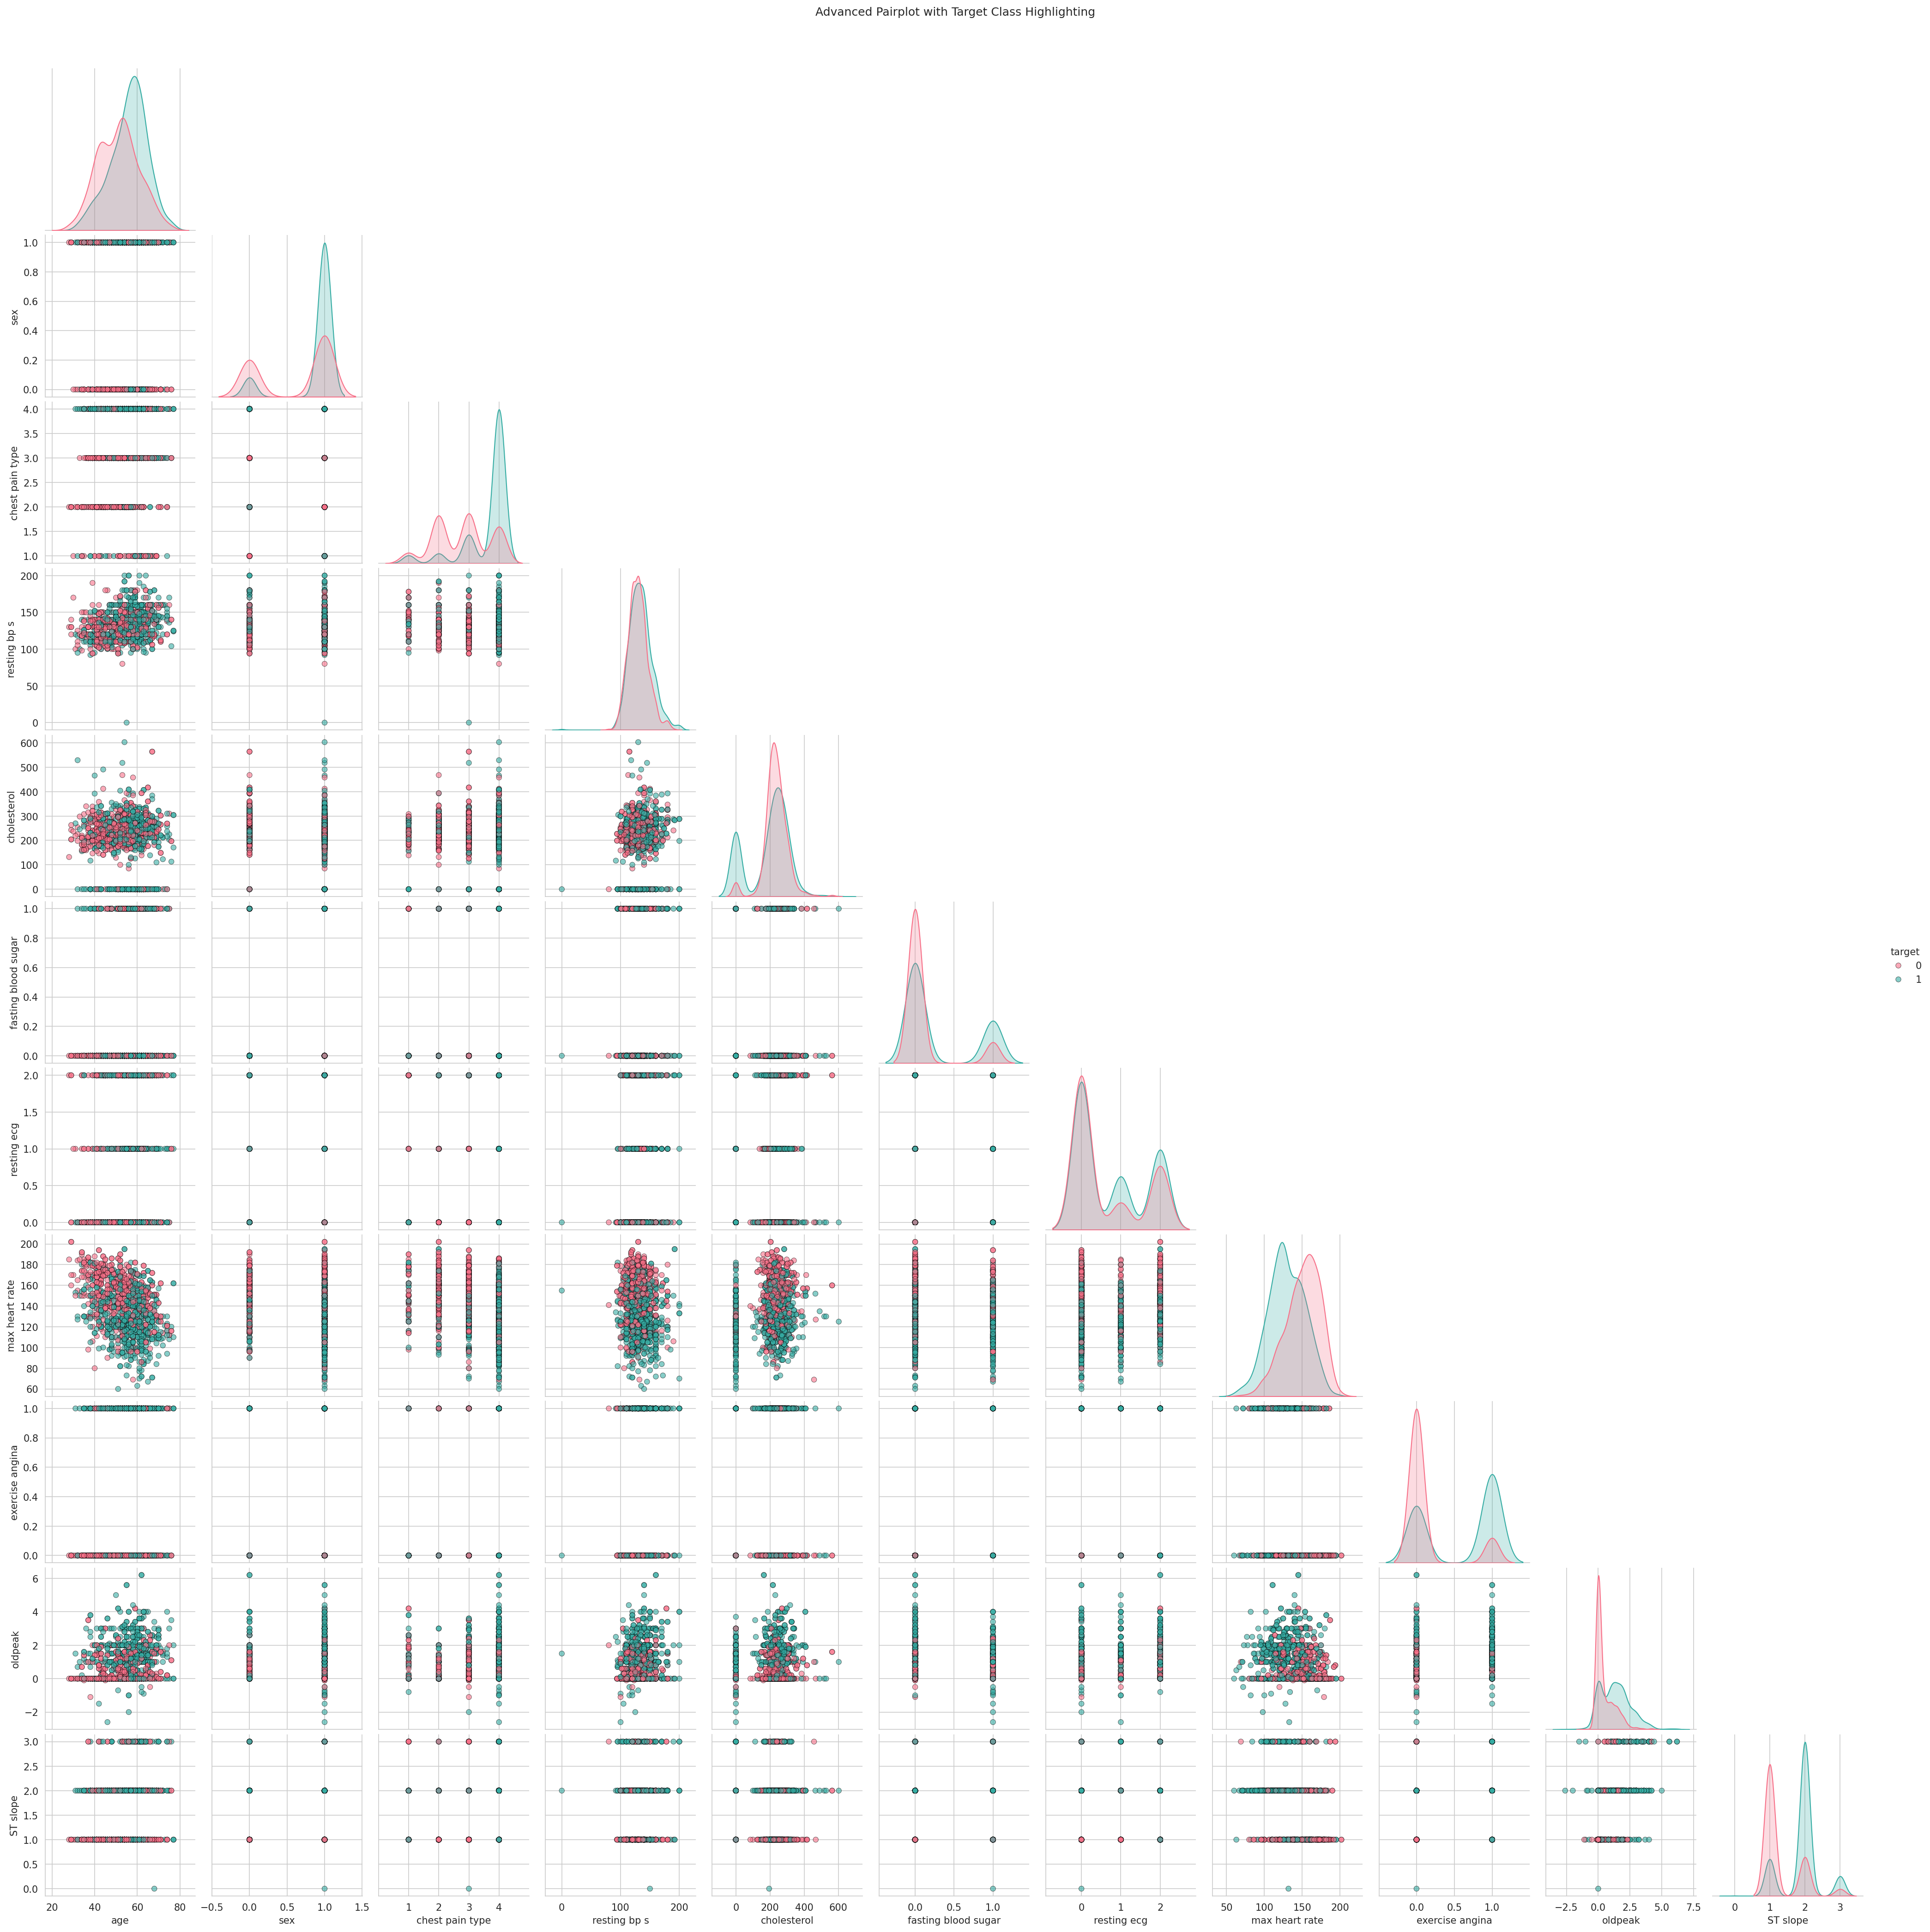

In [37]:
g = sns.pairplot(df, hue='target', palette='husl',
                corner=True, diag_kind='kde',
                plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
                diag_kws={'fill': True})
g.fig.suptitle("Advanced Pairplot with Target Class Highlighting", y=1.02)
plt.show()


In [38]:
fig = px.scatter_3d(df, x='age', y='cholesterol', z='max heart rate',
                   color='target', size=df['oldpeak'].abs(),
                   hover_data=['sex', 'chest pain type', 'resting bp s'],
                   opacity=0.7, title="3D Feature Space Exploration",
                   color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

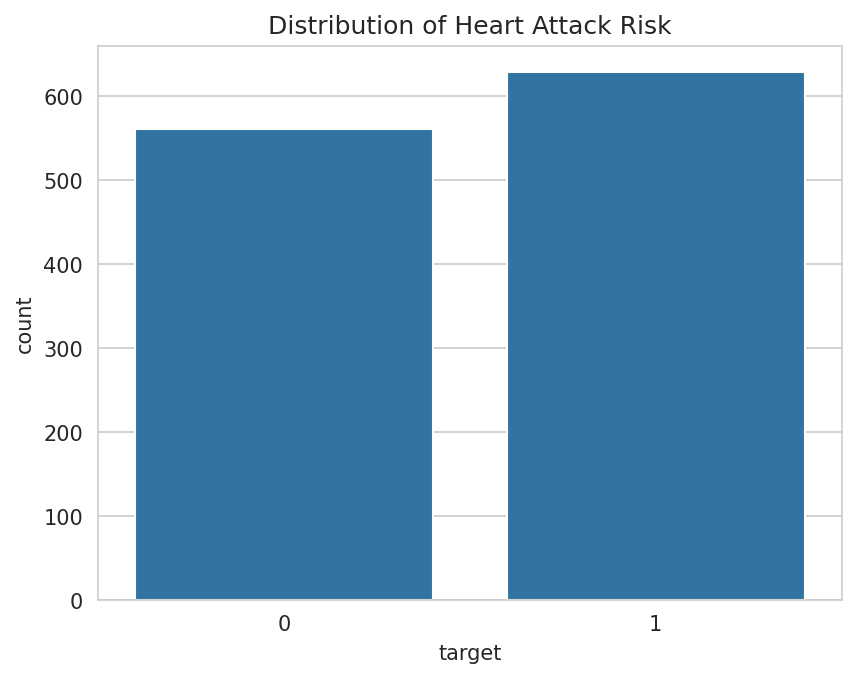

In [39]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Attack Risk')
plt.show()

In [40]:
df.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

In [41]:
df.shape

(1190, 12)

In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
chest pain type,1190.0,3.232773,0.935480,1.0,3.0,4.0,4.00,4.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
resting ecg,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.00,2.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2


In [43]:
df.isnull().sum()

,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


In [44]:
df.duplicated().sum()

np.int64(272)

In [45]:
X = df.drop(columns=['target'])
y = df['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Network": MLPClassifier()
}

In [49]:
rf_param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [0, 1, 2]
}

In [50]:
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [5, 6, 7],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6]
}


In [51]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.3, 0.35],
    'max_depth': [5, 6, 7],
    'min_child_weight': [0, 1, 3],
    'subsample': [0.5, 0.8, 1]
}

In [52]:
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": rf_param_grid,
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    "Gradient Boosting": gb_param_grid,
    "XGBoost": xgb_param_grid,
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    "Naive Bayes": {},
    "MLP Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (50,50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
}

In [53]:
plt.figure(figsize=(10, 8))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>


Processing Logistic Regression
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8529
Precision: 0.8692
Recall: 0.8626
F1 Score: 0.8659
AUC-ROC: 0.9063

Processing Decision Tree
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8992
Precision: 0.9350
Recall: 0.8779
F1 Score: 0.9055
AUC-ROC: 0.9015

Processing Random Forest
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.9580
Precision: 0.9481
Recall: 0.9771
F1 Score: 0.9624
AUC-ROC: 0.9713

Processing SVM
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8992
Precision: 0.9213
Recall: 0.8931
F1 Score: 0.9070
AUC-ROC: 0.9433

Processing KNN
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9370
Precision: 0.9328
Recall: 0.9542
F1 Score: 0.9434
AUC-ROC: 0.9771

Processing Gradient Boosting
Best parameters: {'learning_rate': 0.2, 'max_depth': 6, '

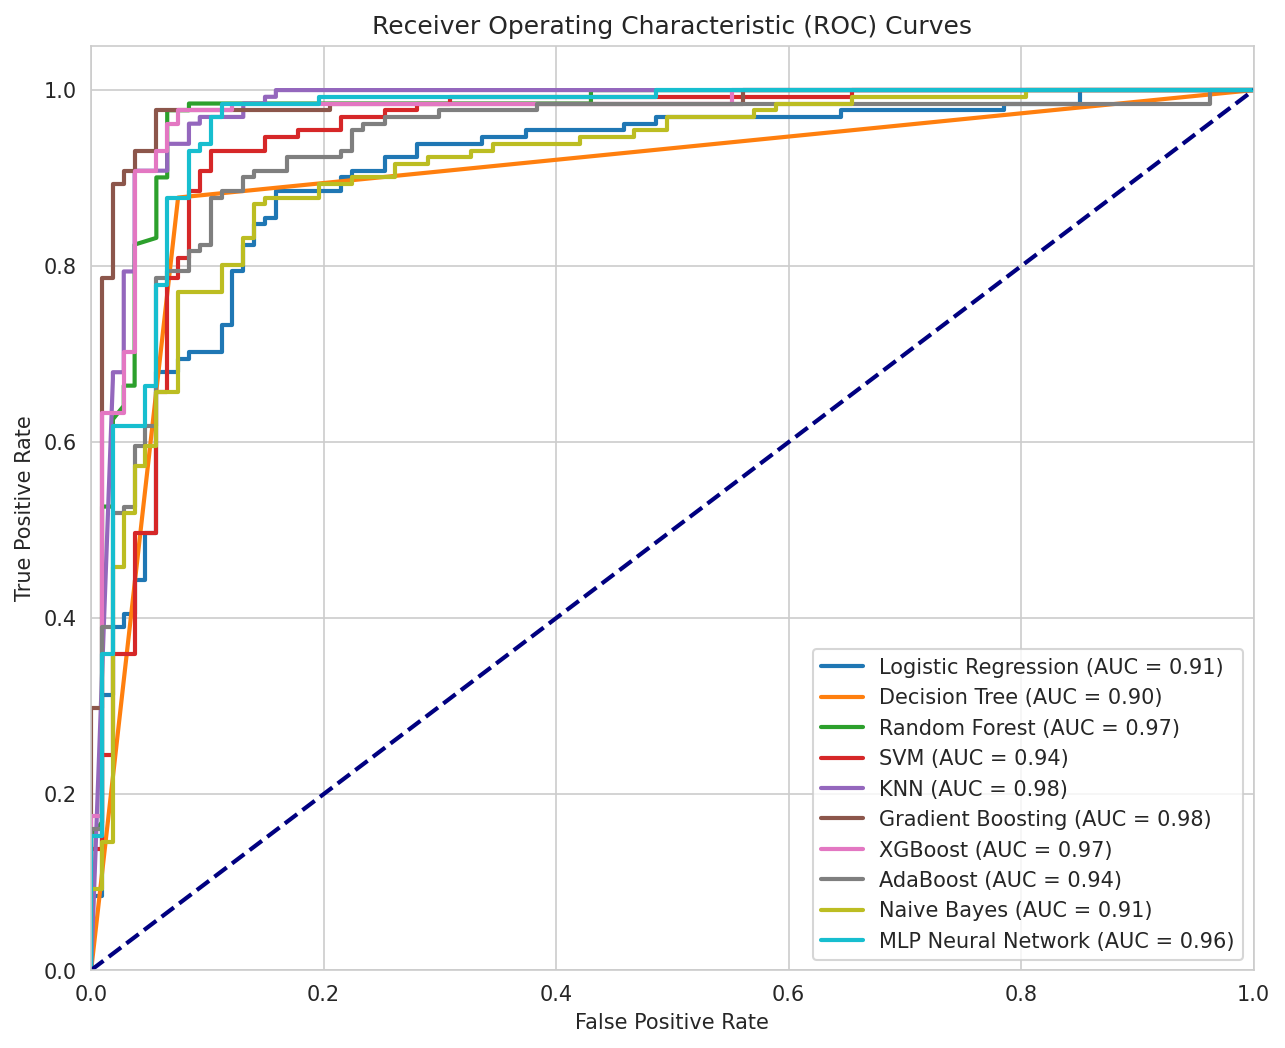

In [54]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Network": MLPClassifier(max_iter=1000)
}


param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest": rf_param_grid,
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    "Gradient Boosting": gb_param_grid,
    "XGBoost": xgb_param_grid,
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    "Naive Bayes": {},
    "MLP Neural Network": {
        'hidden_layer_sizes': [(50,), (100,), (50,50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"\n{'='*30}")
    print(f"Processing {name}")
    print(f"{'='*30}")


    param_grid = param_grids[name]


    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)


    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")


    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_roc:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

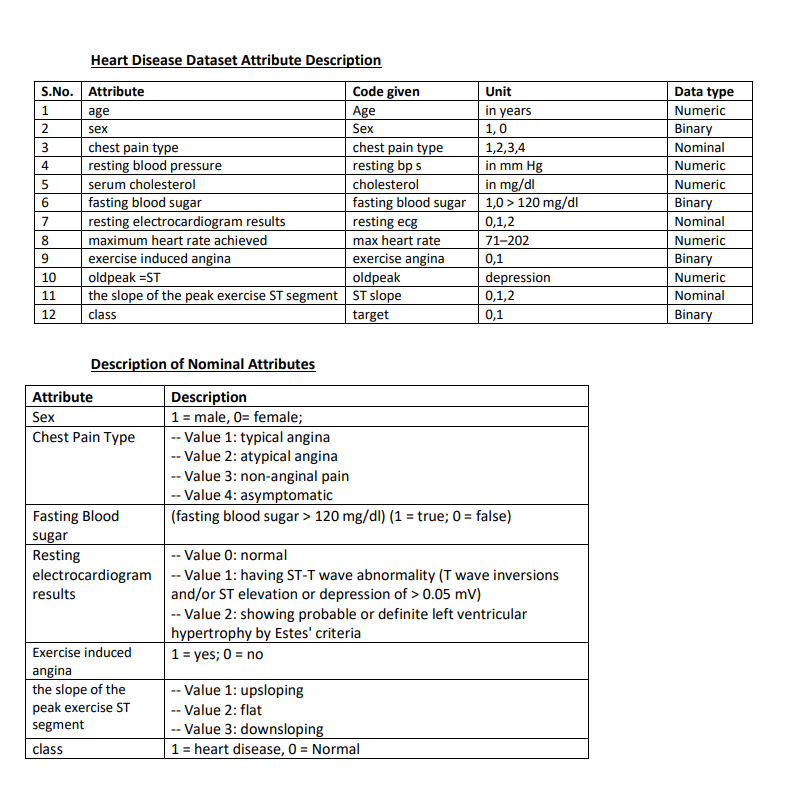

In [55]:
new_data = pd.DataFrame({
    'age': [21],
    'sex': [1],
    'chest pain type': [1],
    'resting bp s': [150],
    'cholesterol': [201],
    'fasting blood sugar': [0],
    'resting ecg': [0],
    'max heart rate': [170],
    'exercise angina': [0],
    'oldpeak': [1.0],
    'ST slope': [2]
})
new_data_scaled = scaler.transform(new_data)
predicted_target = best_model.predict(new_data_scaled)
print("Predicted target:", predicted_target[0])

Predicted target: 0


In [56]:
fig = make_subplots(rows=4, cols=3, subplot_titles=df.columns[:-1])

for i, col in enumerate(df.columns[:-1]):
    row = i//3 + 1
    col_num = i%3 + 1
    fig.add_trace(
        go.Violin(x=df['target'], y=df[col], name=col, box_visible=True),
        row=row, col=col_num
    )

fig.update_layout(height=1000, width=1200,
                title_text="Violin Plots of Features vs Target",
                showlegend=False)
fig.show()

In [63]:
#mlflow-runway

In [64]:


warnings.filterwarnings("ignore")
X = df.drop('target', axis=1)
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "KNeighbors Classifier": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "MLP Classifier": MLPClassifier(max_iter=1000),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if hasattr(model, "predict_proba") else None

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }



mlflow.set_experiment("Heart Disease Prediction")


for name, model in models.items():
    with mlflow.start_run(run_name=name):
        print(f"Training and evaluating {name}...")
        metrics = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)


        mlflow.log_params(model.get_params())


        mlflow.log_metric("accuracy", metrics["accuracy"])
        mlflow.log_metric("precision", metrics["precision"])
        mlflow.log_metric("recall", metrics["recall"])
        mlflow.log_metric("f1", metrics["f1"])
        if metrics["roc_auc"] is not None:
            mlflow.log_metric("roc_auc", metrics["roc_auc"])


        mlflow.sklearn.log_model(model, "model")

        print(f"{name} evaluation metrics: {metrics}")

print("MLflow tracking completed.")

Training and evaluating Logistic Regression...


2025/05/17 08:16:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression evaluation metrics: {'accuracy': 0.8613445378151261, 'precision': 0.8712121212121212, 'recall': 0.8778625954198473, 'f1': 0.8745247148288974, 'roc_auc': np.float64(0.9088249982164515)}
🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/289201512491580559/runs/91e2951a71c8410baeee47992340ab23
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating Decision Tree...


2025/05/17 08:16:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree evaluation metrics: {'accuracy': 0.8949579831932774, 'precision': 0.9274193548387096, 'recall': 0.8778625954198473, 'f1': 0.9019607843137255, 'roc_auc': np.float64(0.8968752229435685)}
🏃 View run Decision Tree at: http://localhost:5000/#/experiments/289201512491580559/runs/afcddafb5952422fb0bd42aa7ef62e48
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating Random Forest...


2025/05/17 08:16:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest evaluation metrics: {'accuracy': 0.9453781512605042, 'precision': 0.9402985074626866, 'recall': 0.9618320610687023, 'f1': 0.9509433962264151, 'roc_auc': np.float64(0.9748519654705001)}
🏃 View run Random Forest at: http://localhost:5000/#/experiments/289201512491580559/runs/30a40238d4ed4f50a970a4a387c9d01b
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating SVC...


2025/05/17 08:16:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC evaluation metrics: {'accuracy': 0.8907563025210085, 'precision': 0.8671328671328671, 'recall': 0.9465648854961832, 'f1': 0.9051094890510949, 'roc_auc': np.float64(0.9476350146250981)}
🏃 View run SVC at: http://localhost:5000/#/experiments/289201512491580559/runs/73c120e60e5143658a70eaa03575ae49
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating KNeighbors Classifier...


2025/05/17 08:16:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNeighbors Classifier evaluation metrics: {'accuracy': 0.8865546218487395, 'precision': 0.8714285714285714, 'recall': 0.9312977099236641, 'f1': 0.9003690036900369, 'roc_auc': np.float64(0.9379325105229365)}
🏃 View run KNeighbors Classifier at: http://localhost:5000/#/experiments/289201512491580559/runs/16c3bcf26c8d461a85b7b9e8ed4d690c
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating Gradient Boosting...


2025/05/17 08:16:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting evaluation metrics: {'accuracy': 0.9159663865546218, 'precision': 0.9172932330827067, 'recall': 0.9312977099236641, 'f1': 0.9242424242424242, 'roc_auc': np.float64(0.9596204608689448)}
🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/289201512491580559/runs/f8bde6532bcd49f2acda551347f7f05f
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating AdaBoost Classifier...


2025/05/17 08:16:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost Classifier evaluation metrics: {'accuracy': 0.8781512605042017, 'precision': 0.875, 'recall': 0.9083969465648855, 'f1': 0.8913857677902621, 'roc_auc': np.float64(0.9364700007134193)}
🏃 View run AdaBoost Classifier at: http://localhost:5000/#/experiments/289201512491580559/runs/0497c29b114d437db2fad6febd76bdbb
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating Gaussian Naive Bayes...


2025/05/17 08:16:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gaussian Naive Bayes evaluation metrics: {'accuracy': 0.8571428571428571, 'precision': 0.8646616541353384, 'recall': 0.8778625954198473, 'f1': 0.8712121212121212, 'roc_auc': np.float64(0.9126061211386174)}
🏃 View run Gaussian Naive Bayes at: http://localhost:5000/#/experiments/289201512491580559/runs/28da857cc72241d88ecd0556490fb459
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating MLP Classifier...


2025/05/17 08:16:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP Classifier evaluation metrics: {'accuracy': 0.9243697478991597, 'precision': 0.9312977099236641, 'recall': 0.9312977099236641, 'f1': 0.9312977099236641, 'roc_auc': np.float64(0.965898551758579)}
🏃 View run MLP Classifier at: http://localhost:5000/#/experiments/289201512491580559/runs/a97f75a03d784cb881dbcec614fb2c84
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
Training and evaluating XGBoost...


2025/05/17 08:16:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost evaluation metrics: {'accuracy': 0.9285714285714286, 'precision': 0.9253731343283582, 'recall': 0.9465648854961832, 'f1': 0.9358490566037736, 'roc_auc': np.float64(0.9720339587643575)}
🏃 View run XGBoost at: http://localhost:5000/#/experiments/289201512491580559/runs/48c8d0d10fbe4970ad46e1d6aba8a683
🧪 View experiment at: http://localhost:5000/#/experiments/289201512491580559
MLflow tracking completed.
